In [25]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from typing import List

#tip_testdaten_template = pd.read_csv("../Dateien/tip_testdaten_template.csv")  
orders = pd.read_parquet("../Dateien/orders.parquet")  
tips_public = pd.read_csv("../Dateien/tips_public.csv")  
order_products_denormalized = pd.read_csv("../Dateien/order_products_denormalized.csv")  


##### *All column names*

In [2]:
def column_names_of_all_table():
    for table in [orders, tips_public, order_products_denormalized]:
        table.drop(columns=["Unnamed: 0"], inplace=True, errors="ignore")
        print(table.columns.tolist())
# column_names_of_all_table()

##### **Amount of Orders of User**

In [3]:
# Creating table with user and amount of orders
def create_orders_per_user_table(orders):
    orders_per_user = orders.groupby("user_id").size().reset_index(name="anzahl_bestellungen")
    return orders_per_user
orders_per_user = create_orders_per_user_table(orders)
orders_per_user 
# Plotting Table for number 1,4,5 10,20, 40, 100 how many user have at least this amount of orders:
for i in [1,4,5,10,20,40,100]:
    print(f"Anzahl der User mit {i} Bestellungen: {len(orders_per_user[orders_per_user['anzahl_bestellungen'] >= i])}".rjust(50))
# Plotting Table for number 1,2,3,4,5 10,20, 40, 100 how many user have this amount of orders:

         Anzahl der User mit 1 Bestellungen: 62032
         Anzahl der User mit 4 Bestellungen: 62032
         Anzahl der User mit 5 Bestellungen: 54334
        Anzahl der User mit 10 Bestellungen: 36154
        Anzahl der User mit 20 Bestellungen: 24276
        Anzahl der User mit 40 Bestellungen: 13693
        Anzahl der User mit 100 Bestellungen: 1289


##### *maximal amount of characters per column as strings*

In [4]:
def maximum_amount_of_characters():
    max_lens = {col: order_products_denormalized[col].astype(str).map(len).max() for col in order_products_denormalized.columns}
    print(max_lens) 
#maximum_amount_of_characters()

##### **Tip shift**

In [5]:
def create_user_tip_features(orders, tips_public, shifts=10, convert_to_int=False, keep_only_tip_columns=False, drop_na=False):
    """
    Erstellt eine Tabelle mit den letzten Trinkgeldern für jeden Nutzer.
    
    Parameters:
    - orders (pd.DataFrame): Tabelle mit Spalten ['order_id', 'user_id', 'order_date']
    - tips_public (pd.DataFrame): Tabelle mit Spalten ['order_id', 'tip']
    - convert_to_int (bool): Wenn True, werden Boolean-Tip-Werte in Integer (True -> 1, False -> 0) umgewandelt
    - keep_only_tip_columns (bool): Wenn True, werden nur Spalten mit 'tip' im Namen behalten
    - drop_na (bool): Wenn True, werden Zeilen mit NaN-Werten entfernt
    
    Returns:
    - pd.DataFrame: Verarbeitete Tabelle mit neuen tip_{i}-Spalten
    """
    # Validierung der Eingabedaten
    required_orders_cols = ['order_id', 'user_id', 'order_date']
    required_tips_cols = ['order_id', 'tip']
    if not all(col in orders.columns for col in required_orders_cols):
        raise ValueError(f"orders muss die Spalten {required_orders_cols} enthalten")
    if not all(col in tips_public.columns for col in required_tips_cols):
        raise ValueError(f"tips_public muss die Spalten {required_tips_cols} enthalten")
    
    # Schritt 1: Merge der Tabellen
    user_tip = orders.merge(tips_public, how="inner", on="order_id")
    if user_tip.empty:
        raise ValueError("Merge ergab keine übereinstimmenden order_id-Werte")
    
    # Schritt 2: Sortieren nach user_id und order_date
    user_tip['order_date'] = pd.to_datetime(user_tip['order_date'], errors='coerce')
    if user_tip['order_date'].isna().any():
        raise ValueError("Einige order_date-Werte konnten nicht in Datetime umgewandelt werden")
    user_tip = user_tip.sort_values(["user_id", "order_date"])
    
    # Schritt 3: Erstellen der tip_{i}-Spalten für die letzten 1 bis X Trinkgelder
    for i in range(1, shifts + 1):
        user_tip[f"tip_{i}"] = user_tip.groupby("user_id")["tip"].shift(i)
    
    # Schritt 4: Optional: Tip-Werte in Integer umwandeln
    if convert_to_int:
        # Konvertiere die tip-Spalte
        user_tip['tip'] = user_tip['tip'].astype(int)
        # Konvertiere die tip_{i}-Spalten und fülle NaN mit 0
        for i in range(1, shifts + 1):
            user_tip[f"tip_{i}"] = user_tip[f"tip_{i}"].fillna(0).astype(int)
    
    # Schritt 5: Optional: Nur tip-Spalten behalten
    if keep_only_tip_columns:
        tip_columns = ['user_id'] + [col for col in user_tip.columns if 'tip' in col.lower()] 
        user_tip = user_tip[tip_columns]
    
    # Schritt 6: Optional: NaN-Werte entfernen
    if drop_na:
        user_tip = user_tip.dropna()
    
    return user_tip

# Beispielaufruf (angenommen, orders und tips_public sind geladen):
user_tip = create_user_tip_features(orders, tips_public, shifts = 10, convert_to_int=True, keep_only_tip_columns=True, drop_na=False)
user_tip.head(10)

,user_id,tip,tip_1,tip_2,tip_3,tip_4,tip_5,tip_6,tip_7,tip_8,tip_9,tip_10
0,3,1,0,0,0,0,0,0,0,0,0,0
1,3,1,1,0,0,0,0,0,0,0,0,0
2,3,1,1,1,0,0,0,0,0,0,0,0
3,3,1,1,1,1,0,0,0,0,0,0,0
4,3,1,1,1,1,1,0,0,0,0,0,0
5,3,1,1,1,1,1,1,0,0,0,0,0
6,3,0,1,1,1,1,1,1,0,0,0,0
7,3,1,0,1,1,1,1,1,1,0,0,0
8,3,0,1,0,1,1,1,1,1,1,0,0
9,3,1,0,1,0,1,1,1,1,1,1,0


##### **Trend**

Trend: sinus


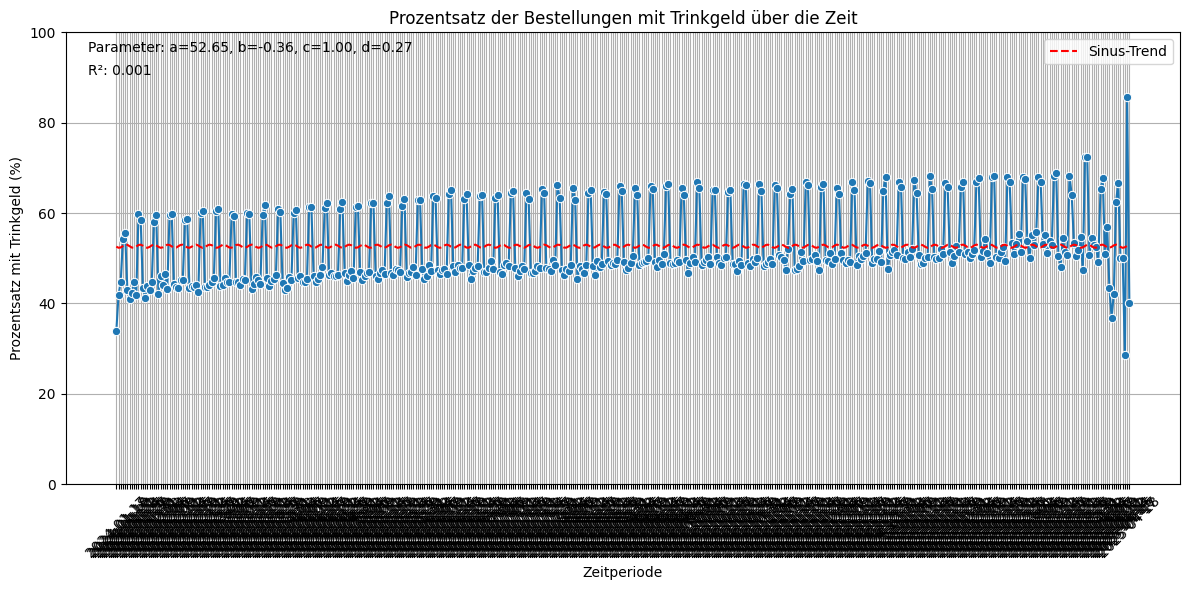

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit

def plot_tip_time_series(orders, tips_public, period='M', trend_type='linear'):
    """
    Erstellt eine Zeitreihe des Prozentsatzes der Bestellungen mit Trinkgeld und visualisiert sie als Liniendiagramm
    mit einer angepassten Trendkurve und R²-Wert.
    
    Parameters:
    - orders (pd.DataFrame): Tabelle mit Spalten ['order_id', 'user_id', 'order_date']
    - tips_public (pd.DataFrame): Tabelle mit Spalten ['order_id', 'tip']
    - period (str): Aggregationsperiode ('Y', 'Q', 'M', 'W', 'D', 'H' oder z. B. 'W-MON', 'Q-MAR')
    - trend_type (str): Art der Trendkurve ('linear', 'exponential', 'quadratic', 'cubic', 'log', 'sqrt', 'power', 'sigmoid', 'sinus')
    
    Returns:
    - None: Speichert das Diagramm als 'tip_time_series.png'
    """
    # Schritt 1: user_tip-Tabelle erstellen
    user_tip = create_user_tip_features(orders, tips_public, convert_to_int=False, keep_only_tip_columns=False, drop_na=False)
    
    # Schritt 2: Aggregation nach Zeitperiode
    user_tip['order_date'] = pd.to_datetime(user_tip['order_date'])  # Sicherstellen, dass order_date Datetime ist
    try:
        if period in ['Y', 'A', 'Q', 'M', 'W', 'D', 'H'] or period.startswith(('Y-', 'A-', 'Q-', 'W-')):
            user_tip['time_period'] = user_tip['order_date'].dt.to_period(period)
        else:
            raise ValueError("Ungültige Periode. Erlaubte Werte: 'Y', 'A', 'Q', 'M', 'W', 'D', 'H' oder z. B. 'W-MON', 'Q-MAR'")
    except ValueError as e:
        raise ValueError(f"Fehler bei der Umwandlung in Zeitperiode: {e}")
    
    # Berechne den Prozentsatz der Bestellungen mit Trinkgeld
    tip_percentage = user_tip.groupby('time_period')['tip'].mean().reset_index(name='tip_percentage')
    tip_percentage['tip_percentage'] = tip_percentage['tip_percentage'] * 100  # In Prozent umwandeln
    tip_percentage['time_period'] = tip_percentage['time_period'].astype(str)  # Für die Darstellung
    
    # Schritt 3: Liniendiagramm erstellen
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=tip_percentage, x='time_period', y='tip_percentage', marker='o')
    
    # Trendkurve berechnen
    # Zeitindex (beginnt bei 1 für logarithmische Funktion, um ln(0) zu vermeiden)
    x = np.arange(len(tip_percentage)) + 1  # Für log, power, sigmoid
    x_alt = np.arange(len(tip_percentage))  # Für Funktionen, die x=0 erlauben
    y = tip_percentage['tip_percentage'].values
    
    # Definition der Trendfunktionen
    if trend_type == 'linear':
        def trend_func(x, a, b):
            return a + b * x
        label = 'Linearer Trend'
        x_data = x_alt
    elif trend_type == 'exponential':
        def trend_func(x, a, b):
            return a * np.exp(b * x)
        label = 'Exponentieller Trend'
        x_data = x_alt
    elif trend_type == 'quadratic':
        def trend_func(x, a, b, c):
            return a + b * x + c * x**2
        label = 'Quadratischer Trend'
        x_data = x_alt
    elif trend_type == 'cubic':
        def trend_func(x, a, b, c, d):
            return a + b * x + c * x**2 + d * x**3
        label = 'Kubischer Trend'
        x_data = x_alt
    elif trend_type == 'log':
        def trend_func(x, a, b):
            return a + b * np.log(x)
        label = 'Logarithmischer Trend'
        x_data = x
    elif trend_type == 'sqrt':
        def trend_func(x, a, b):
            return a + b * np.sqrt(x)
        label = 'Wurzeltrend'
        x_data = x_alt
    elif trend_type == 'power':
        def trend_func(x, a, b):
            return a * x**b
        label = 'Potenztrend'
        x_data = x
    elif trend_type == 'sigmoid':
        def trend_func(x, L, k, x0):
            return L / (1 + np.exp(-k * (-x - x0)))   # eigentlich L/(1+e^(-k*(x-x0))) aber x ist hier experimentell negativ 
        label = 'Sigmoid-Trend'
        x_data = x
    elif trend_type == 'sinus':
        def trend_func(x, a, b, c, d):
            return a + b * np.sin(c * x + d)
        label = 'Sinus-Trend'
        x_data = x_alt
    else:
        raise ValueError("trend_type muss einer von 'linear', 'exponential', 'quadratic', 'cubic', 'log', 'sqrt', 'power', 'sigmoid', 'sinus' sein")
    
    # Kurvenanpassung
    try:
        popt, _ = curve_fit(trend_func, x_data, y, maxfev=10000)
    except RuntimeError as e:
        print(f"Warnung: Kurvenanpassung fehlgeschlagen für {trend_type}: {e}")
        popt = [0] * trend_func.__code__.co_argcount  # Fallback: Null-Parameter
    
    # Trendkurve zeichnen
    y_pred = trend_func(x_data, *popt)
    plt.plot(tip_percentage['time_period'], y_pred, color='red', linestyle='--', label=label)
    
    # R²-Wert berechnen
    ss_tot = np.sum((y - np.mean(y))**2)  # Total Sum of Squares
    ss_res = np.sum((y - y_pred)**2)  # Residual Sum of Squares
    r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
    
    # Parameter und R² anzeigen
    param_str = ', '.join([f'{chr(97+i)}={p:.2f}' for i, p in enumerate(popt)])  # a=..., b=..., etc.
    plt.text(0.02, 0.98, f'Parameter: {param_str}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    plt.text(0.02, 0.93, f'R²: {r_squared:.3f}', transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    
    plt.title('Prozentsatz der Bestellungen mit Trinkgeld über die Zeit')
    plt.xlabel('Zeitperiode')
    plt.ylabel('Prozentsatz mit Trinkgeld (%)')
    plt.ylim(0, 100)  # Y-Achse auf 0-100 setzen
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()  # Legende hinzufügen
    plt.tight_layout()
    #plt.savefig('tip_time_series.png')  # Speichern statt plt.show()
    plt.show()
    plt.close()

all_functions: List[str] = ['linear', 'exponential', 'quadratic', 'cubic', 'log', 'sqrt', 'power', 'sigmoid', 'sinus']
all_functions: List[str] = ["sinus"]

for i in all_functions:
    print(f"Trend: {i}")
    plot_tip_time_series(orders, tips_public, period='D', trend_type=i)
#plot_tip_time_series(orders, tips_public, period='M', trend_type='cubic')


##### Creating new features for user in new table

In [7]:
def new_feture_tabel_for_users():
    d = pd.DataFrame(orders.groupby("user_id")["order_id"].count()) \
        .merge(orders[["user_id"]], how="inner", on="user_id") \
        .drop_duplicates()[["user_id", "order_id"]] \
        .sort_values("user_id") \
        .set_index("user_id") \
        .rename(columns={"order_id": "n_orders"}) \
        .join(user_tip[["user_id", "tip"]].groupby("user_id")["tip"].sum().reset_index().set_index("user_id").rename(columns={"tip": "n_tips"})) \
        .join(user_tip[["user_id", "tip"]].groupby("user_id")["tip"].mean().reset_index().set_index("user_id").rename(columns={"tip": "mean_tip"})) \
        .join(user_tip[["user_id", "tip"]].groupby("user_id")["tip"].std().reset_index().set_index("user_id").rename(columns={"tip": "std_tip"})) \
        .join(user_tip[["user_id", "tip"]].groupby("user_id")["tip"].min().reset_index().set_index("user_id").rename(columns={"tip": "min_tip"})) \
        .join(user_tip[["user_id", "tip"]].groupby("user_id")["tip"].max().reset_index().set_index("user_id").rename(columns={"tip": "max_tip"}))   # does at least one tip exist (max=True)  # does a user tip only (min=True) 

    return d.reset_index()

    d.head(1)
# only prints it out, not save it to a variable
new_feture_tabel_for_users()

,user_id,n_orders,n_tips,mean_tip,std_tip,min_tip,max_tip
0,3,13,10,0.833333,0.389249,0,1
1,5,5,2,0.500000,0.577350,0,1
2,6,4,0,0.000000,0.000000,0,0
3,13,13,8,0.666667,0.492366,0,1
4,15,23,9,0.409091,0.503236,0,1
...,...,...,...,...,...,...,...
62027,206187,35,32,0.941176,0.238833,0,1
62028,206189,7,1,0.166667,0.408248,0,1
62029,206204,5,1,0.250000,0.500000,0,1
62030,206206,68,15,0.223881,0.419989,0,1


##### **Correlation tip - 2 and tip - 1 and tip**

In [8]:
def tip_from_tip1_and_tip2():
    user_tip_2 = user_tip[["user_id", "tip", "tip_1", "tip_2"]].dropna().astype({"tip": "int32", "tip_1": "int32", "tip_2": "int32"}).copy()

    summ = user_tip_2.query("tip_1 == 0 and tip_2 == 0").tip.sum()
    amount = user_tip_2.query("tip_1 == 0 and tip_2 == 0").tip.count()
    print(f"The sum of tips is {summ} and the amount of tips is {amount}; the percentage is {summ/amount:.2%}.")

    summ = user_tip_2.query("tip_1 == 0 and tip_2 == 1").tip.sum()
    amount = user_tip_2.query("tip_1 == 0 and tip_2 == 1").tip.count()
    print(f"The sum of tips is {summ} and the amount of tips is {amount}; the percentage is {summ/amount:.2%}.")

    summ = user_tip_2.query("tip_1 == 1 and tip_2 == 0").tip.sum()
    amount = user_tip_2.query("tip_1 == 1 and tip_2 == 0").tip.count()
    print(f"The sum of tips is {summ} and the amount of tips is {amount}; the percentage is {summ/amount:.2%}.")

    summ = user_tip_2.query("tip_1 == 1 and tip_2 == 1").tip.sum()
    amount = user_tip_2.query("tip_1 == 1 and tip_2 == 1").tip.count()
    print(f"The sum of tips is {summ} and the amount of tips is {amount}; the percentage is {summ/amount:.2%}.")

Das selbe Ergebnis für tip = 1 ist, wenn man nur tip_1 gegeben ist